In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
from astropy.io import fits
from astropy import wcs
import pandas as pd
import sys
from tqdm import tqdm
from glob import glob
import csv
from multiprocessing import Pool
import time as tm

# Conversion UT to GJD

細かいことは気にしない GJDでいくし観測開始時刻でいきます  
今後図とかにするならば観測開始時刻 + exposure time/2の時間でだします? (そのときにはfits headerのJDつかえばいいのか)

In [14]:
#UT in YYYY-MM-DD HH:MM

In [21]:
from astropy.time import Time 

def UTtoGJD(dates_list):
    JD_list=[]
    for d in dates_list: 
        JD_list.append(Time(d).jd)
    return JD_list

In [24]:
#example
UTtoGJD(["2021-11-10 14:37"])

[2459529.109027778]

# Transit Prediction

In [25]:
def phase(OBS_JD):
    
    n = np.floor((OBS_JD-T0)/P)
    tr_before = T0 + n * P
    ph = (OBS_JD - tr_before)/P
    return ph

In [50]:
def phase_l(OBS_JD_list):
    
    li =[]
    for OBS_JD in OBS_JD_list:
        li.append(phase(OBS_JD))
    return li

## Parameter

In [27]:
T0_before = 2458816.697706 #previous: from NASA exoplanet archive
P_before = 2.500715

In [28]:
T0 = 2459206.74743329
P = 2.50032476  #From John's updated ephemeris

## Previous IRD observation 

In [88]:
HST_list=['2021-01-29 22:53', '2021-09-08 25:13', '2021-09-29 24:30', '2021-10-14 27:00',\
          '2021-10-19 23:31', '2021-10-19 27:07', \
          '2021-10-21 22:56', '2021-10-21 27:00',\
          '2021-10-26 23:39', '2021-10-26 28:25',\
          '2021-11-11 24:00']
#2021-10-14: instrument problem
HST_list

['2021-01-29 22:53',
 '2021-09-08 25:13',
 '2021-09-29 24:30',
 '2021-10-14 27:00',
 '2021-10-19 23:31',
 '2021-10-19 27:07',
 '2021-10-21 22:56',
 '2021-10-21 27:00',
 '2021-10-26 23:39',
 '2021-10-26 28:25',
 '2021-11-11 24:00']

In [89]:
#ちょっとあまりにその場凌ぎだが +10 = +24-14

UTC_list=[]

for HST in HST_list:
    hr = str(int(HST[11:13])-14).zfill(2)
    day = str(int(HST[8:10])+1).zfill(2)
    UTC_list.append(HST[:8]+day+' '+hr+HST[-3:])
UTC_list

['2021-01-30 08:53',
 '2021-09-09 11:13',
 '2021-09-30 10:30',
 '2021-10-15 13:00',
 '2021-10-20 09:31',
 '2021-10-20 13:07',
 '2021-10-22 08:56',
 '2021-10-22 13:00',
 '2021-10-27 09:39',
 '2021-10-27 14:25',
 '2021-11-12 10:00']

In [90]:
GJD_list=UTtoGJD(UTC_list)
GJD_list

[2459244.8701388887,
 2459466.967361111,
 2459487.9375,
 2459503.0416666665,
 2459507.896527778,
 2459508.046527778,
 2459509.8722222224,
 2459510.0416666665,
 2459514.902083333,
 2459515.1006944445,
 2459530.9166666665]

In [91]:
phase_list=phase_l(GJD_list)
phase_list

[0.24710158001806168,
 0.07445144100394838,
 0.46141749614685906,
 0.502299427976005,
 0.4439916388646974,
 0.5039838455998208,
 0.2341667697137693,
 0.3019357439024085,
 0.2458498884290656,
 0.3252840141704592,
 0.650851186449656]

In [92]:
phase_list

[0.24710158001806168,
 0.07445144100394838,
 0.46141749614685906,
 0.502299427976005,
 0.4439916388646974,
 0.5039838455998208,
 0.2341667697137693,
 0.3019357439024085,
 0.2458498884290656,
 0.3252840141704592,
 0.650851186449656]

In [93]:
np.sin(np.array(phase_list)*2*np.pi)

array([ 0.99983418,  0.45091678,  0.24005356, -0.01444723,  0.34469224,
       -0.02502863,  0.99505563,  0.9472278 ,  0.99966004,  0.89019495,
       -0.81214898])

Text(0, 0.5, 'predicted RV (Normalized)')

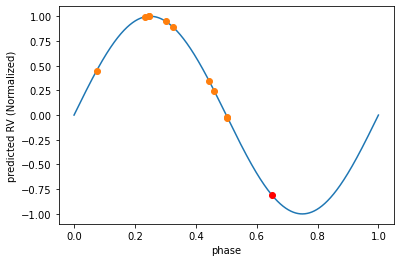

In [99]:
x = np.linspace(0, 1, 10000)
pl.plot(x, np.sin(x*2*np.pi))
pl.plot(phase_list[:-1], np.sin(np.array(phase_list[:-1])*2*np.pi),'o')
pl.plot(phase_list[-1], np.sin(np.array(phase_list[-1])*2*np.pi),'o',color='r')
pl.xlabel('phase')
pl.ylabel('predicted RV (Normalized)')

In [3]:
OBS1_start = 2459242.7291667 #1/28 05:30 UT
OBS1_end = 2459242.9166667  #1/28 10:00 UT 

OBS2_start = 2459244.7291667 #1/30 05:30 UT
OBS2_end = 2459244.9166667 #1/30 10:00 UT

OBS21_start = 2459247.7291667 #2/2 05:30 UT ハワイ2/1
OBS21_end = 2459247.9166667 #2/2 10:00 UT

OBS22_start = 2459248.7291667 #2/3 05:30 UTハワイ2/2
OBS22_end = 2459248.9166667 #2/3 10:00 UT

OBS23_start = 2459249.7291667 #2/4 05:30 UTハワイ2/3
OBS23_end = 2459249.9166667 #2/4 10:00 UT

OBS3_start = 2459271.7395833 #2/26 ０5:45 UT
OBS3_end = 2459271.8541667 #2/26 ０８:30 UT

OBS31_start = 2459275.75 #3/2 06:00 UT
OBS31_end = 2459275.83333 #3/2 08:00 UT

In [12]:
phase(2459466.70833 + 8/24)

0.10416846948870263

In [16]:
phase(2459456.75000)

0.9880378380088298

In [15]:
phase(2459502.70833)

0.36898207975598885

In [6]:
phase(T0+10.99*P)

0.9899999999214757

In [7]:
print(phase(OBS31_start))
print(phase(OBS31_end))

0.5974416660426819
0.6307693365727285


In [10]:
print(phase(OBS21_start))
print(phase(OBS21_end))

0.39056416414576367
0.465554422611228


In [11]:
print(phase(OBS22_start))
print(phase(OBS22_end))

0.7905122092949066
0.865502467760371


In [14]:
print(phase(OBS23_start))
print(phase(OBS23_end))

0.1904602545910908
0.26545051305655515


In [48]:
def near_025(OBS_JD):
    n = np.floor((OBS_JD-T0)/P)
    return T0 + n * P + 0.25*P

def near_075(OBS_JD):
    n = np.floor((OBS_JD-T0)/P)
    return T0 + n * P + 0.75*P

In [50]:
near_075(OBS22_start)  #→2021-Jan-30 09:03:26.13

2459248.6278730202

# J.2000での位置

In [13]:
def deg_to_hr(RA_d,Dec_d): #65.280648, +48.819831
    
    RA_h = np.floor(RA_d/15.)
    resid_h = RA_d/15. - RA_h
    RA_m = np.floor(resid_h*60.)
    resid_m = resid_h*60. - RA_m
    RA_s = resid_m*60.
    
    if RA_s < 10.0:
        RA_output="{:02}:{:02}:0{:.2f}".format(int(RA_h),int(RA_m),(RA_s))
    else:
        RA_output="{:02}:{:02}:{:.2f}".format(int(RA_h),int(RA_m),(RA_s))
        
    Dec_1 = np.floor(abs(Dec_d))
    resid_1 = abs(Dec_d)-Dec_1
    Dec_2 = np.floor(resid_1*60)
    resid_2 = resid_1*60 - Dec_2
    Dec_3 = resid_2*60
    
    if Dec_d < 0.:
        if Dec_3 < 10.0:
            Dec_output = "-{:02}:{:02}:0{:.2f}".format(int(Dec_1),int(Dec_2),(Dec_3))
        else:
            Dec_output = "-{:02}:{:02}:{:.2f}".format(int(Dec_1),int(Dec_2),(Dec_3))
    else:
        if Dec_3 < 10.0:
            Dec_output = "+{:02}:{:02}:0{:.2f}".format(int(Dec_1),int(Dec_2),(Dec_3))
        else:
            Dec_output = "+{:02}:{:02}:{:.2f}".format(int(Dec_1),int(Dec_2),(Dec_3))
        
    
    return RA_output, Dec_output

In [14]:
deg_to_hr(65.280648, +48.819831) 

('04:21:07.36', '+48:49:11.39')

たとえばTOI1634なら

In [15]:
#03:45:33.75 37:06:44.21
deg_to_hr(56.39061,+37.11228)

('03:45:33.75', '+37:06:44.21')

In [18]:
#J2000
ra_d_2015 = 56.39061
dec_d_2015 =+37.11228
prop_ra = 81.6429
prop_dec=13.486 #mas/year

ra_d_2000 = ra_d_2015 - 15.5 * prop_ra /3600. * 1.0e-3
dec_d_2000 = dec_d_2015 - 15.5 * prop_dec /3600. * 1.0e-3

In [19]:
deg_to_hr(ra_d_2000,dec_d_2000)

('03:45:33.66', '+37:06:44.00')

## TOI1696の2000年の位置

In [21]:
ra_d_2015 = 65.280648
dec_d_2015=+48.819831
prop_ra = 12.9303 
prop_dec = -19.1779 

ra_d_2000 = ra_d_2015 - 15.5 * prop_ra /3600. * 1.0e-3
dec_d_2000 = dec_d_2015 - 15.5 * prop_dec /3600. * 1.0e-3
deg_to_hr(ra_d_2000,dec_d_2000)

('04:21:07.34', '+48:49:11.69')

r-band magはどうすれば

# TESS - lightkurve

https://docs.lightkurve.org/tutorials/02-how-to-recover-the-first-tess-candidate.html

In [2]:
from lightkurve import search_targetpixelfile
tpf= search_targetpixelfile("TIC 470381900", mission='TESS').download(quality_bitmask='hardest');

In [3]:
tpf.mission

'TESS'

In [4]:
tpf.plot(aperture_mask=tpf.pipeline_mask);

/home/mori/miniconda3/envs/py3/lib/python3.8/site-packages/lightkurve/utils.py:453: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(cax, ax=ax, norm=norm, label=clabel)


In [6]:
header =tpf.hdu[1].header
header['CROWDSAP']

0.52400798

In [8]:
header['FLFRCSAP'] 

0.62631744

In [9]:
dep=ufloat(11012,1500)

In [10]:
(dep*1.0e-6)**0.5

0.10493807697875923+/-0.007147072079011027

# TSM, ESM

https://arxiv.org/pdf/1805.03671.pdf

ランキングを作る！！！！！
→ いいかんじなら図を作る

TSMとESMを使っている論文をチェックしてやり方を考える

In [14]:
def TSM(rp, mp, teq, rs, m_J) :
    return 0.190*rp**3 * teq / (mp * rs **2) * 10**(-m_J/5.)

In [305]:
from astropy import units as u

h = con.h
pi = con.pi
c = con.c
k = con.k

def planck(wav, T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity

def ESM(rp, teq, rs, teff, m_K) :
    tday = 1.1*teq
    
    bb_tday=planck(7.5e-6, tday)
    bb_teff=planck(7.5e-6, teff)
    
    #Here, Rp/Rs is in absolute value...
    
    rp_rs=(rp*6.3781e8)/(rs*6.957e10)
    #rp_rs=((rp*u.earthRad.cgs)/(rs*u.solRad.cgs)).value
    
    esm= 4.29e6* bb_tday/bb_teff * (rp_rs)**2 * 10**(-m_K/5)
    
    return esm

これをExoplanet Archiveからおとした全部の惑星と比べる(chronosつかいたい)

### TOI 1696.01	/ TIC 470381900.01

In [323]:
Rp_tg = 3.1 #Rearth #ちょっとかわった
Mp_tg  = 11.4 #pm3.0, Mearth  #wolfieから求めている、使い方しりたい！
Teq_tg  = 506 #pm 24, K

Teff_tg  = 3350 
Rs_tg  = 0.271 #pm 0.016, Rsun

mJ_tg  =12.233
mK_tg  = 11.331

dep_tg=((Rp_tg*6.3781e8)/(Rs_tg*6.957e10))**2

In [308]:
TSM_tg=TSM(Rp_tg , Mp_tg , Teq_tg , Rs_tg , mJ_tg )
TSM_tg

12.233360281339822

In [309]:
ESM_tg=ESM(Rp_tg , Teq_tg , Rs_tg , Teff_tg , mK_tg )
ESM_tg

6.500716903025603

mass-radiusプロット(もしかしたらmagとかのほうがいいか？)にTSM, ESMでサイズや色をかえたものをつくる
TSM, ESMを使っている人の

## LP791-18c (TOI736.01) as comparison

In [310]:
Rp = 2.31 #Rearth
Mp =  8 #5-20 in Crossfield(2019)
Teq = 370 

Teff = 2960
Rs = 0.171

mJ=11.559
mK = 10.644

In [311]:
TSM_LP=TSM(Rp, Mp, Teq, Rs, mJ)
TSM_LP

18.067957358140276

In [312]:
ESM_LP=ESM(Rp, Teq, Rs, Teff, mK)
ESM_LP

4.0389635837266695

## Import data from NASA Exoplanet Archive

ちょいふる？ Exoplanet Archiveだと2440ですが…

In [313]:
all_planets = pd.read_csv('PS_2021.01.04_00.04.58.csv', skiprows=292)
all_planets.columns

Index(['rowid', 'pl_name', 'hostname', 'pl_letter', 'hd_name', 'hip_name',
       'tic_id', 'gaia_id', 'default_flag', 'sy_snum',
       ...
       'sy_kepmagerr2', 'rowupdate', 'pl_pubdate', 'releasedate', 'pl_nnotes',
       'st_nphot', 'st_nrvc', 'st_nspec', 'pl_nespec', 'pl_ntranspec'],
      dtype='object', length=287)

In [314]:
all_planets=all_planets[all_planets['default_flag']==1]
len(all_planets)

4324

In [315]:
planets=all_planets[all_planets['st_teff']<4000]
len(planets)

300

In [316]:
planets=all_planets[all_planets['st_teff']<4000]

#TSM
planets=planets[planets['pl_rade'].notna()]
planets=planets[planets['pl_masse'].notna()]
planets=planets[planets['pl_eqt'].notna()]
planets=planets[planets['st_rad'].notna()]
planets=planets[planets['sy_jmag'].notna()]
planets=planets.reset_index()
len(planets)

#ESM

#planets=planets[planets['pl_rade'].notna()]
#planets=planets[planets['pl_eqt'].notna()]
#planets=planets[planets['st_rad'].notna()]
#planets=planets[planets['sy_kmag'].notna()]

35

- pl_masse: mass
- pl_cmasse: mass* sin(i) / sin(i)

こっちつかってみてもいいかもね

In [317]:
Rp = planets['pl_rade']
Mp = planets['pl_masse']
Teq = planets['pl_eqt']
Rs = planets['st_rad']
mJ = planets['sy_jmag']
planets['TSM'] = TSM(Rp, Mp, Teq, Rs, mJ)
planets_TSM = planets

In [318]:
planets_TSM.sort_values('TSM', ascending=False).loc[:,['pl_name','TSM', 'pl_eqt', 'pl_rade']].reset_index()

,index,pl_name,TSM,pl_eqt,pl_rade
0,3,GJ 3470 b,44.642496,594.0,4.570
1,20,LTT 1445 A b,43.585297,433.0,1.380
2,29,TRAPPIST-1 b,42.630620,400.0,1.086
3,15,L 98-59 d,35.094616,409.0,1.570
4,5,GJ 357 b,28.814360,525.0,1.217
5,1,GJ 1132 b,28.047743,529.0,1.130
6,14,L 98-59 c,26.921961,517.0,1.350
7,17,LHS 1140 c,26.264820,438.0,1.282
8,33,TRAPPIST-1 f,25.994124,219.0,1.045
9,31,TRAPPIST-1 d,22.858706,288.0,0.772


In [348]:
planets=all_planets[all_planets['st_teff']<4000]
planets=all_planets[all_planets['pl_rade']<4]

#ESM

planets=planets[planets['pl_rade'].notna()]
planets=planets[planets['pl_eqt'].notna()]
planets=planets[planets['st_rad'].notna()]
planets=planets[planets['st_teff'].notna()]
planets=planets[planets['sy_kmag'].notna()]
planets=planets.reset_index()
len(planets)

293

In [320]:
Rp = planets['pl_rade']
Teq = planets['pl_eqt']
Rs = planets['st_rad']
Teff = planets['st_teff']
mK = planets['sy_kmag']

planets['ESM']= ESM(Rp,Teq, Rs, Teff, mK)

planets_ESM = planets

In [321]:
planets_ESM.sort_values('ESM', ascending=False).loc[:,['pl_name','ESM', 'pl_eqt', 'pl_rade']].reset_index()

,index,pl_name,ESM,pl_eqt,pl_rade
0,0,2MASS J21402931+1625183 A b,11351.507617,2075.0,10.310
1,70,NGTS-1 b,78.985675,790.0,14.908
2,7,HATS-6 b,50.528769,713.0,11.187
3,55,Kepler-45 b,50.352809,1000.0,10.760
4,8,HATS-71 b,38.044696,587.0,11.478
...,...,...,...,...,...
86,49,Kepler-1649 b,0.059164,307.0,1.017
87,84,TOI-700 d,0.056918,269.0,1.144
88,90,TRAPPIST-1 g,0.048429,199.0,1.127
89,51,Kepler-1652 b,0.019715,268.0,1.600


No handles with labels found to put in legend.


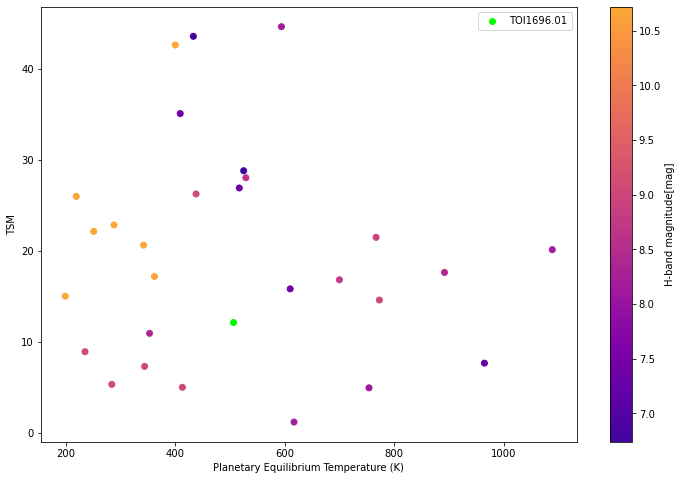

In [346]:
f = pl.figure(figsize=(12,8))

df = planets_TSM[planets_TSM['sy_hmag']<11]

sc =pl.scatter(df['pl_eqt'],df['TSM'],  alpha=1, c=df['sy_hmag'], cmap=inferno_t)
#sc =pl.scatter(df['pl_eqt'],df['TSM'],  s=df['pl_trandep']*100, alpha=1, c=df['sy_hmag'], cmap=inferno_t, label=': Depth=1%')
pl.colorbar(sc, label='H-band magnitude[mag]')
pl.legend(loc="upper right", markerscale=1., scatterpoints=1, fontsize=15)

pl.scatter(Teq_tg, TSM_tg, facecolor='lime', label='TOI1696.01')

pl.xlabel('Planetary Equilibrium Temperature (K)')
pl.ylabel(r'TSM')

pl.legend()
#pl.text(210,0.6, 'TRAPPIST-1 Planets',fontsize=18, c='orange')
#pl.xlim(820, 100)
#f.savefig('S21A_scatter2.png')

No handles with labels found to put in legend.


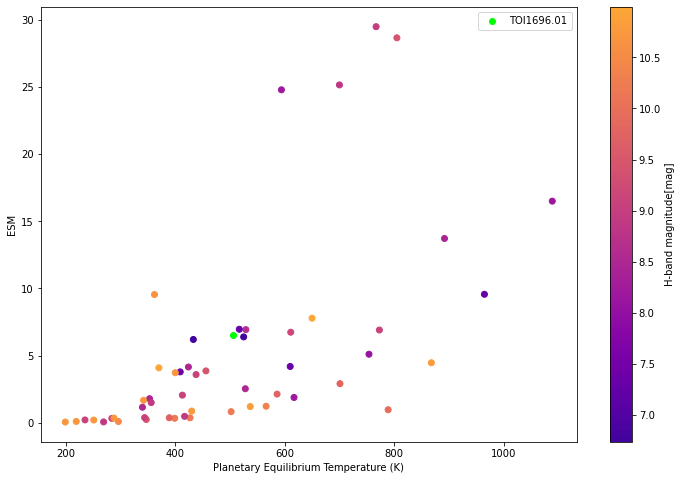

In [347]:
f = pl.figure(figsize=(12,8))

df = planets_ESM[planets_ESM['sy_hmag']<11]

#sc =pl.scatter(df['pl_eqt'],df['ESM'],  s=df['pl_trandep']*100, alpha=1, c=df['sy_hmag'], cmap=inferno_t, label=': Depth=1%')
sc =pl.scatter(df['pl_eqt'],df['ESM'],  alpha=1, c=df['sy_hmag'], cmap=inferno_t)
pl.colorbar(sc, label='H-band magnitude[mag]')
pl.legend(loc="upper right", markerscale=1., scatterpoints=1, fontsize=15)

#pl.scatter(Teq_tg, ESM_tg,  (dep_tg*100), facecolor='skyblue', edgecolors='red', lw=2,  label='TOI1696.01')
pl.scatter(Teq_tg, ESM_tg, facecolor='lime', label='TOI1696.01')

pl.xlabel('Planetary Equilibrium Temperature (K)')
pl.ylabel(r'ESM')

#pl.text(210,0.6, 'TRAPPIST-1 Planets',fontsize=18, c='orange')

#pl.xlim(820, 100)
pl.legend()

#f.savefig('S21A_scatter2.png')

samples: planets with Teff < 4000K & H < 11mag with all information needed

## chronosの使い方さっそくわすれちゃったんだが

In [3]:
import chronos

TypeError: 'NoneType' object is not subscriptable

In [ ]:
tois=chronos.get_tois()
tois.columns

#### K2について   

[K2 data search](https://archive.stsci.edu/k2/data_search/search.php)   
ここからもデータとってこれるけど今日は見てみるだけ。    
PDCSAP: Pre-search Data Conditioning Simple Aperture Photometry 

[K2 Products](https://archive.stsci.edu/k2/hlsps.html) 


#### データ選択

[NASA Explanet Archive](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS&constraint=default_flag=1)

#### 解析　
以下の解析は、惑星の情報がほとんどわかっていない状況(のような想定)。   
すでにある程度トランジットの情報がわかっている場合はpriorも変わってくる。トランジットから何が知りたいかによってもpriorは異なる。  
また、地上観測ではこれに加えて装置や地球大気による変動も考慮する。   

[EVEREST](https://luger.dev/everest/)

[DACE](https://dace.unige.ch/dashboard/index.html)    
使った感じ、uniform priorは変えるべきかも、、、

[batman](https://www.cfa.harvard.edu/~lkreidberg/batman/)

(今日は使わないけれど、トランジット解析その他ツール)   

[PyTransit](https://github.com/hpparvi/PyTransit)

[TAC-maker](http://astro.shu-bg.net/software/TAC-maker)     
windows ユーザー向け、、、? (ちょっと遊んでみたけど、あらかじめある程度のパラメータわかった状態)

[ktransit](https://github.com/mrtommyb/ktransit)

#### その他   

[Handbook of Exoplanets/ 解析ツールまとめたパート](https://ui.adsabs.harvard.edu/abs/2018haex.bookE..13D/abstract)


## Import data   
注) このセクションは1回データ保存までやってしまった後はマークダウンにしてしまっていいです。EVERESTからdataを持ってきて保存する作業だけなので1回しか動かす必要がありません。

In [34]:
import everest
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import astropy
from astropy.stats import sigma_clip

In [35]:
everest.Everest?

In [36]:
#()内でターゲット名を指定。K2 data searchとかで出てくるK2/EPIC ID
#star = everest.Everest(201862715)
EPIC_id=246911830
star = everest.Everest(EPIC_id)

#data validation summary
star.dvs()

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 246911830.
INFO  [everest.user.DownloadFile()]: Found cached file.


(comments)   
EVERESTでは、主にPLD,CBVという一次処理を終えたデータが生成されます。(CBVが一番装置の影響を取り除けていることが多い。)   
しかし今回は、フラックスの誤差を簡単に取得できるということで、EVERESTによって処理される前のフラックスを使います、、、なので正直EVEREST使う必要あるのかという感じです。。。

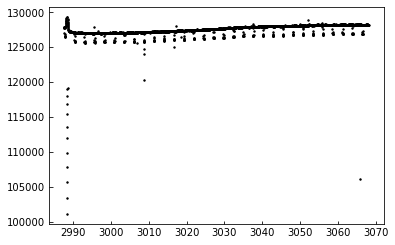

In [37]:
flux_pld = star.flux
flux_cbv = star.fcor
fraw = star.fraw
fraw_err = star.fraw_err
time = star.time

plt.scatter(time, flux_pld, s=2, c='black')
#plt.scatter(time, flux_cbv, s=1.5, c='dodgerblue')

(comments)   
直前のplotを見ると、はじめの方で明らかにおかしな挙動が見えています。   
K2 missionの最初の方のキャンペーンでは、このような装置による変動が見えることがあります。　　　
今回は全てのデータを使う必要はないので、ざっくりとはじめの部分のデータは削除します。　　
また、5σで外れ値も除きます。

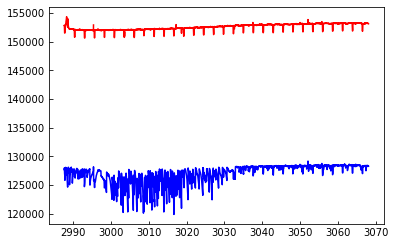

In [38]:
#外れ値を除く
clip_fraw = sigma_clip(fraw,sigma=5)
flux_pld2 = flux_pld[~clip_fraw.mask]
fraw2 = fraw[~clip_fraw.mask]
fraw_err2 = fraw_err[~clip_fraw.mask]
time_pld = time[~clip_fraw.mask]

df = pd.DataFrame(np.c_[time_pld,fraw2,fraw_err2,flux_pld2])
df.columns = ['time','fraw','fraw_err','flux_pld']

#remove pointing error data　(すごいざっくりはじめのおかしな挙動の部分のデータを除く)
data = df[df['time'] > 2980]

#dataを保存する
data.to_csv('EPIC-{}.csv'.format(EPIC_id), index=False, header=True)

plt.plot(data['time'], data['flux_pld']+2.5e4, c='red')
plt.plot(data['time'], data['fraw'], c='blue')

(comments)  
EVERESTで処理されたライトカーブ(赤)、処理前のライトカーブ(青)をplotしています。(わかりやすいようにあえてずらしています。)　　
青に現れている細かな変動をEVERESTは除けていることがわかります。

## Analysis

In [39]:
from astropy.timeseries import BoxLeastSquares
import batman
from scipy.optimize import minimize
from IPython.display import display, Math
import corner
import numpy as np
import matplotlib.pyplot as plt
import emcee
import pandas as pd

from multiprocessing import Pool

In [40]:
#関数の定義

def transitsonly(jdb, flux, fluxerror, per, tc, oot = False):
    """
    per, tc = period and epoch of the planet
    
    if oot, return-out-of transit lightcurve
    """

    mask_intransit = ((jdb-tc)/per %1. < 0.20) | ((jdb-tc)/per %1. > 0.80)

    if oot:
        return(jdb[~mask_intransit], flux[~mask_intransit], fluxerror[~mask_intransit])
    if not oot:
        return(jdb[mask_intransit], flux[mask_intransit], fluxerror[mask_intransit])

def log_likelihood(theta, x, y, yerr):
    # t0, per, rp, a, inc, ecc, w, baseline = theta    
    model = f_batman(x, *theta)
    sigma2 = yerr ** 2 
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2. * np.pi*sigma2))

def f_batman(x, t0,per,rp,a,inc,baseline=0.0, ecc=0,w=90,  u=[0.34, 0.28],limb_dark ="quadratic"):
    """
    Function for computing transit models for the set of 8 free paramters
    x - time array
    """
    params = batman.TransitParams()
    params.t0 = t0                     #time of inferior conjunction
    params.per = per                  #orbital period
    params.rp =  rp         #planet radius (in units of stellar radii)
    params.a = a                      #semi-major axis (in units of stellar radii)
    params.inc = inc                     #orbital inclination (in degrees)
    params.ecc = ecc                     #eccentricity
    params.w = w                       #longitude of periastron (in degrees)
    params.u = u                #limb darkening coefficients [u1, u2]
    params.limb_dark = limb_dark       #limb darkening model

    m = batman.TransitModel(params, x)    #initializes model
    flux_m = m.light_curve(params)          #calculates light curve
    return np.array(flux_m)+baseline


def log_prior(theta):
    # The parameters are stored as a vector of values, so unpack them
    t0, per, rp, a, inc, baseline = theta
    # We're using only uniform priors:                
    if  (t0 < priors[0]  or t0 > priors[1])or\
        (per < priors[2] or per > priors[3]) or \
        (rp < priors[4] or rp >priors[5]) or \
        (a < priors[6] or a > priors[7]) or \
        (baseline < priors[8] or baseline > priors[9])or\
        (inc < 0 or inc > 90):
        return -np.inf
    return 0.0

def lnprior(p):
    """
    Example of using a gaussian prior
    """
    Rp, T, a, t0 = theta[:4]
    # The planet radius, period and semi-major axis cannot be negative
    if Rp < 0 or a < 0:
        return -np.inf
    # A Gaussian prior on the orbital period
    period_mu = (32.939623 * u.d).to(u.h).value
    period_sigma = (0.000100 * u.d).to(u.h).value
    period_prob = 1 / period_sigma / (2 * np.pi) ** 0.5 * np.exp(-0.5 * ((T - period_mu) / (period_sigma)) ** 2)
    return np.log(period_prob)

## The full log-probability function is:

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

          time           fraw   fraw_err       flux_pld
0  2987.581662  127675.899213  11.728386  127817.308024
1  2987.602095  127792.325390  11.730191  127797.703581
2  2987.622527  127899.142548  11.731420  127825.614502
3  2987.642960  127979.297927  11.732303  127792.414978
4  2987.663392  127263.169702  11.712007  126989.020464


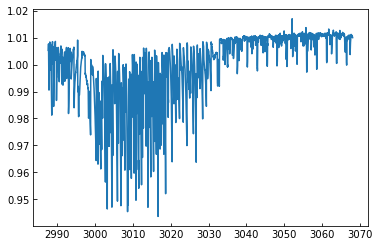

In [41]:
# Read data
df = pd.read_csv('EPIC-{}.csv'.format(EPIC_id))
#header=0, parse_dates=True, , index_col=[0,1,2,3], sep=',',, index_col=[0,1,2]
time = np.array(df['time'])
flux = np.array(df['fraw'])
ferr = np.array(df['fraw_err'])

'''
#remove long trend
res1=np.polyfit(time, flux, 1)
y1 = np.poly1d(res1)(time)
flux_trend = flux - y1 + np.average(flux)
flux_norm = flux_trend/np.average(flux_trend)
'''
'''
DLした状態のデータではなぜかコードがうまく流れなかったので、すごい適当にフラックスをフラックスの平均で割ってみています。
厳密に考えると非常によろしくない作業だと思います。。。最小値0、最大値1に正規化とかするのがいいのかなと思ったり、、、
'''
flux_norm = flux/np.average(flux)
ferr_norm = ferr/np.average(flux)

print(df[:5])
plt.plot(time, flux_norm)

### Periodgram   

トランジットによる減光のパワーが一番大きいとして周期解析

Text(0, 0.5, 'power')

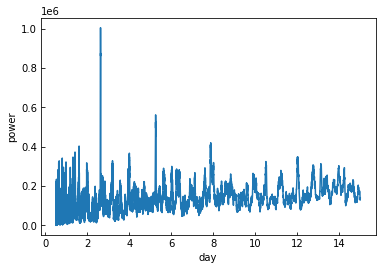

In [42]:
# set up the model based on the data:
model = BoxLeastSquares(time, flux_norm, dy=ferr_norm)

# Compute the Periodogram
periodogram = model.autopower(duration=0.2, minimum_period=0.5, maximum_period=15,minimum_n_transit=3)

# plot it
plt.plot(periodogram.period, periodogram.power)  
plt.xlabel('day' )
plt.ylabel('power')

直前のplotで、一番強いパワーを持つのがトランジット周期です。先行研究では	d=2.6556777dayくらい。　　
(この周期の整数倍のところにも強めのシグナルが見えています。)
以下は、この一番強いパワーの周期がトランジット周期だろうと思って進めています。　　　
今回はそれで問題ないですが、必ずしもトランジット周期が一番強いシグナルになるわけではないので注意です。

Period with max Power: P= 2.6257 days, Tc = 2.3536. 
Alternative Epoch: 3066.532322351374


Text(0, 0.5, 'Relative flux')

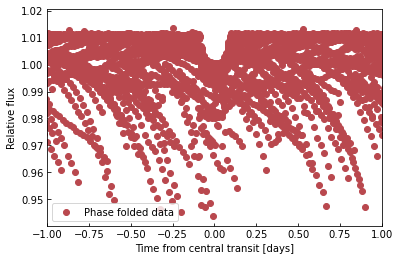

In [43]:
#周期解析で求まった一番強いパワーを持つ周期でデータを分割して重ね合わせる

max_power = np.argmax(periodogram.power)
period_bls = periodogram.period[max_power]
epoch_bls = periodogram.transit_time[max_power]
depth_bls = (periodogram.depth[max_power])
duration_bls = periodogram.duration[max_power]

print('Period with max Power: P= {:.4f} days, Tc = {:.4f}. '
      .format(period_bls, epoch_bls))


# Compute stats:
stats = model.compute_stats(periodogram.period[max_power],
                            periodogram.duration[max_power],
                            periodogram.transit_time[max_power])

print('Alternative Epoch: {}'.format(stats['transit_times'][-1]))
epoch_bls = stats['transit_times'][0]

# orbital phase fold data:
phase = (time - epoch_bls) % period_bls / period_bls
phase[np.where(phase>0.5)] -= 1 




## plot the phase fold
plt.plot(phase*period_bls, flux_norm, "o", color='xkcd:dusty red', label='Phase folded data')
plt.legend()
plt.xlim(-1, 1)
plt.xlabel("Time from central transit [days]")
plt.ylabel("Relative flux")

In [44]:
### Fit using BLS as start-guess
# def f_batman(x, t0,per,rp,a,inc,baseline=0.0, ecc=0,w=90,  u=[0.35, 0.30],limb_dark ="quadratic"):
#	guess = np.array([epoch_bls, period_bls, depth_bls**0.5, 15., 90., 0.0, 90., 0.0])
a = ((period_bls/365.)**2)**(1/3)*215. # semimajor axis in solar radii (asumin 1 Msol, 1 Rsol host)
guess = np.array([epoch_bls, period_bls, depth_bls**0.5, a, 88.5, 0.0])


# cut out transit data to make things easier :-)
time_t, flux_t, ferr_t = transitsonly(time, flux_norm, ferr_norm, guess[1], guess[0])

# Magic:
nll = lambda *args: -log_likelihood(*args)
soln = minimize(nll, guess, args=(time_t, flux_t, ferr_t))

labels = ["t0", "per", "rp", "a", "inc",'baseline', "ecc", 'w', ]


for idx in range(len(soln.x)):
    print("{} : {} ({})".format(labels[idx], soln.x[idx], guess[idx]))

t0 : 2987.7295786217924 (2987.7616622753917)
per : 2.6269272739308223 (2.6256886691994037)
rp : 0.08941023419314564 (0.08767373110540676)
a : 5.248465165750907 (8.011958731419412)
inc : 89.9968483015172 (88.5)
baseline : -0.0002201903009666084 (0.0)


Text(0, 0.5, 'Normalised flux')

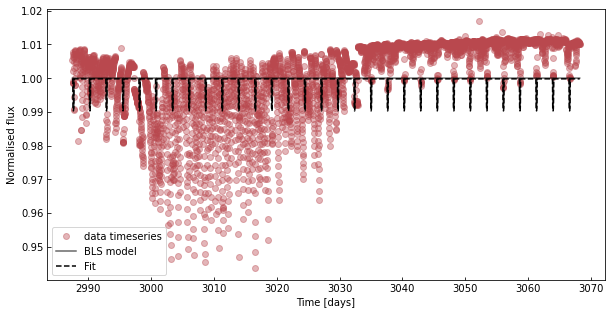

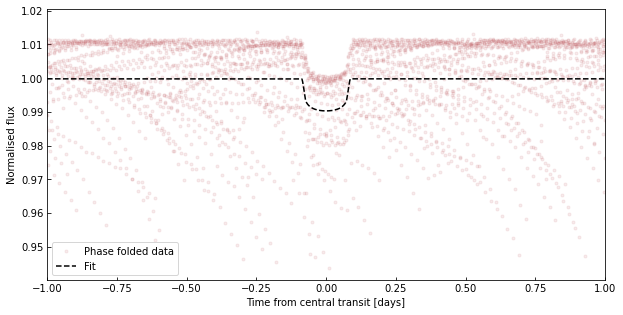

In [45]:
## compute model for BLS and fit
## Create time array for BLS model and fit:
t = np.linspace(np.min(time), np.max(time[-1]), 10000)
flux_m = f_batman(t, *guess)
flux_fit = f_batman(t, *soln.x)

## Phasefold data time-array
phase = (time - soln.x[0]) % soln.x[1] / soln.x[1]
phase[np.where(phase>0.5)] -= 1 


## Phase bls model time-array + sort
phase_blsmodel = (t - epoch_bls) % period_bls / period_bls
phase_blsmodel[np.where(phase_blsmodel>0.5)] -= 1 
sorted_idx = np.argsort(phase_blsmodel)

## phasefold fit time array + sort
phase_fit = (t - soln.x[0]) % soln.x[1] / soln.x[1]
phase_fit[np.where(phase_fit>0.5)] -= 1 
sorted_fit = np.argsort(phase_fit)


# Plot: 
## Plot data & model together, timeseries
plt.figure(figsize=(10,5))
plt.plot(time, flux_norm, "o", color='xkcd:dusty red', label='data timeseries', alpha=0.4)
plt.plot(t, flux_m, 'k', label='BLS model', alpha=0.6)
plt.plot(t, flux_fit, '--k', label='Fit')
plt.legend()
plt.xlabel("Time [days]")
plt.ylabel("Normalised flux")

## Plot data & model together, phase fold
plt.figure(figsize=(10,5))
plt.plot(phase*soln.x[1], flux_norm, ".", color='xkcd:dusty red', label='Phase folded data', alpha=0.1)
plt.plot(phase_fit[sorted_fit]*soln.x[1], flux_fit[sorted_fit], '--k', label='Fit')
plt.legend()
plt.xlim(-1, 1)
plt.xlabel("Time from central transit [days]")
plt.ylabel("Normalised flux")

In [46]:
priors = [guess[0]-guess[1]/2, guess[0]+guess[1]/2,   #Tc
          guess[1]-0.1, guess[1]+0.1,              #period
         0, 1.0,
         0, np.inf,
         -0.1, 0.1]

# def log_prior(theta):
#     # The parameters are stored as a vector of values, so unpack them
#     t0, per, rp, a, inc, baseline, ecc, w= theta
#     # We're using only uniform priors:
#     if priors[0] < t0 < priors[1] and \
#     priors[2] < per < priors[3] and \
#     priors[4] < rp < priors[5] and \
#     priors[6] < a < priors[7] and \
#     priors[8] < inc < priors[9] and\
#     priors[10] < baseline < priors[11] and\
#     0.0 < ecc < 1.0 and \
#     0.0 < w < 180:
#         return 0.0
#     return -np.inf



In [47]:
ndim = len(soln.x)
nwalkers = ndim*8  # Number of walkers. It is recommended to be at least higher than twice 
                   # the amount of parameters being fit


# theta = [t0, per , rp,  a, inc, baseline ]
order_of_mag = np.array([1e-3, 1e-3, 1e-4, 0.1, 0.1, 1e-5])

pos = soln.x + order_of_mag * np.random.randn(nwalkers, ndim)

# If you want to use parallelization
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time_t, flux_t, ferr_t),pool=pool)
    # This line below will fit the entire data set, incl OOT. Time consuming.
    # sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time, flux, flux_error),pool=pool)
    sampler.run_mcmc(pos, 10000, progress=True)
    
# If you *do not* want to use parallelization
# sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time, flux, flux_error))
# sampler.run_mcmc(pos, 1000, progress=True);

  0%|          | 0/10000 [00:00<?, ?it/s]/home/mori/miniconda3/envs/py3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [01:59<00:00, 83.48it/s]


[82.78947294 59.24714147 78.7216969  71.37899438 89.30881801 75.77231441]


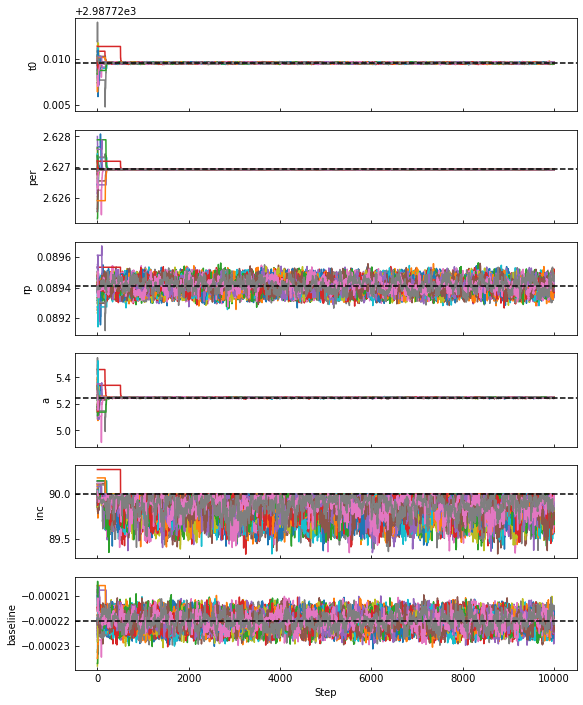

In [48]:
try:
    tau = sampler.get_autocorr_time()
    print(tau)
except:
    print('Tau bad!')
    
fig, axes = plt.subplots(ndim, sharex=True, figsize=(9.0, 12.0))

for i in range(ndim):
    axes[i].plot(sampler.chain[:,:,i].T)
    axes[i].set_ylabel(labels[i])
    axes[i].axhline(y=soln.x[i], linestyle='--', lw=1.5, color='k')
axes[-1].set_xlabel('Step')
plt.show() 

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

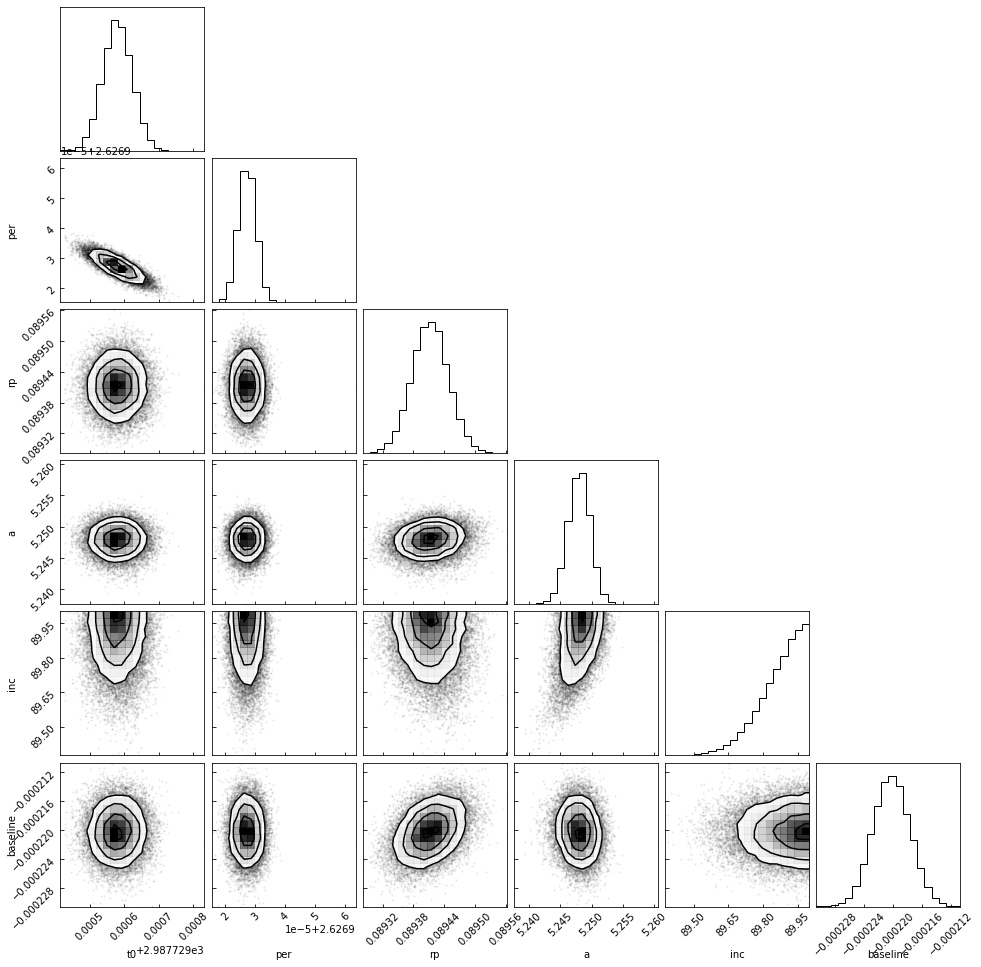

In [50]:
# flat_samples = sampler.get_chain(discard=10, thin=1, flat=True)
flat_samples = sampler.get_chain(discard=500, thin=20, flat=True)


fit = np.array([])

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    fit = np.append(fit, [mcmc[1]])
    
fig = corner.corner(flat_samples, labels=labels)
    

[2.98776166e+03 2.62568867e+00 8.76737311e-02 8.01195873e+00
 8.85000000e+01 0.00000000e+00]
[ 2.98772958e+03  2.62692724e+00  8.94125434e-02  5.24798555e+00
  8.98932205e+01 -2.20218939e-04]


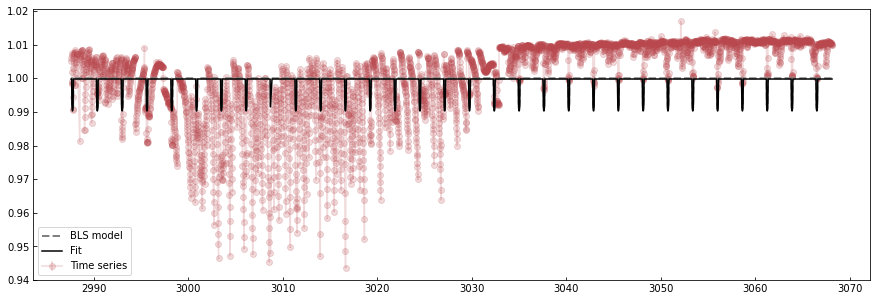

In [51]:
print(guess)


transit_fit = fit[:-1]

print(fit)

plt.figure(figsize=(15,5))

flux_m = f_batman(time, *guess)
plt.plot(time, flux_m, '--', color='gray', label='BLS model', lw=2, zorder=3)

flux_m = f_batman(time, *fit )
plt.plot(time, flux_m, 'k', label='Fit', lw=1.5, zorder=10)



plt.errorbar(time, flux_norm, ferr_norm,marker="o", color='xkcd:dusty red', label='Time series', alpha=0.2)


# plt.xlim(58330, 58335)
# plt.ylim(0.99,1.01)
plt.legend()

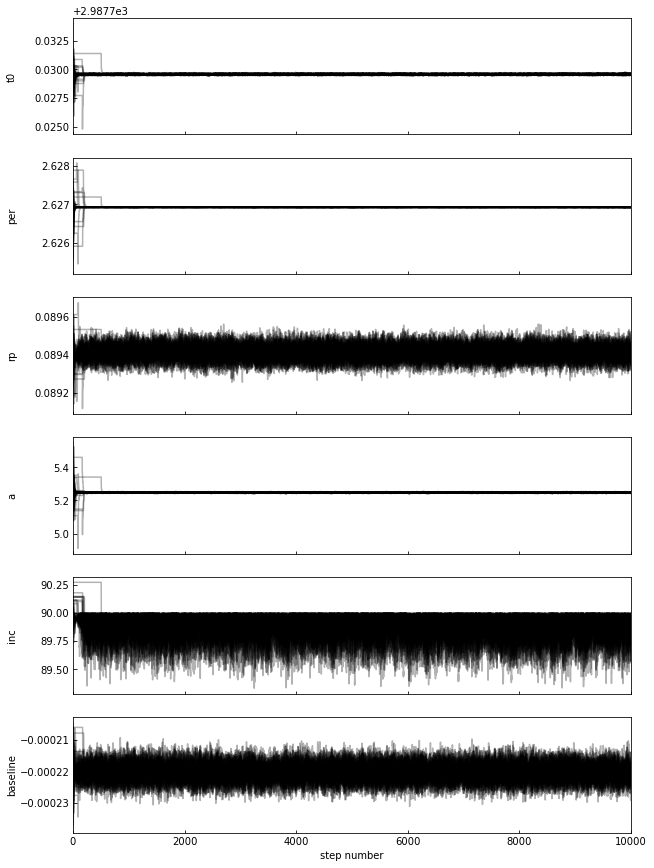

In [52]:
fig, axes = plt.subplots(ndim, figsize=(10, 15), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [53]:
for idx in range(len(fit)):
    print("{} = {}\t{}".format(labels[idx],soln.x[idx], fit[idx]))

t0 = 2987.7295786217924	2987.7295791488023
per = 2.6269272739308223	2.626927243867077
rp = 0.08941023419314564	0.08941254343185862
a = 5.248465165750907	5.247985549275818
inc = 89.9968483015172	89.89322054035944
baseline = -0.0002201903009666084	-0.0002202189390256427


Text(0, 0.5, 'Relative flux')

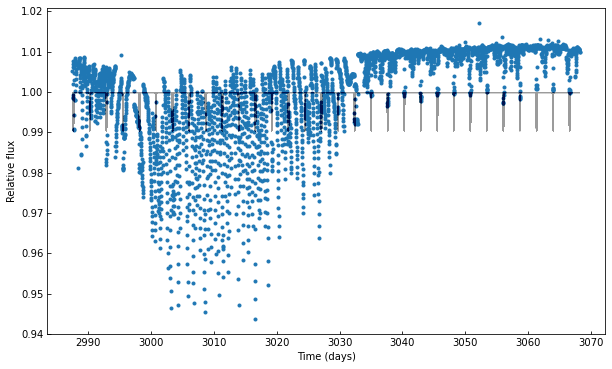

In [54]:
plt.figure(figsize=(10,6))

# Final plot of phasefolded data + model:
    


inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    sample_flux = f_batman(t, *sample)
    plt.plot(t, sample_flux, color='k', alpha=0.005, zorder=10)
plt.errorbar(time, flux_norm, yerr=ferr_norm, fmt='.')
plt.xlabel('Time (days)')
plt.ylabel('Relative flux')
#plt.xlim(58331.5,58333)